# Notebook 3 - Hidden Markov models

This notebook will contain the implementations of Hidden Markov Models for this project.
Some of the code is commented out, so that these sections dont have ot be rerun every run through the program.

In [1]:
# imports
from hmmlearn import hmm
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import nltk
import pickle
import matplotlib.pyplot as plt



In [2]:

# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

# Now do some data engineering to get the targets into the format I want.
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.

df_m_lab = df_lab[['target', 'time', 'turkId']]     # m for markov
lab_dups = len(df_m_lab)-len(df_m_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}\n')
df_m_lab = df_m_lab.drop_duplicates()

df_m_turk = df_turk[['target', 'time', 'turkId']]
turk_dups = len(df_m_turk)-len(df_m_turk.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_m_turk) * 100}')
df_m_turk = df_m_turk.drop_duplicates()

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_lab = df_m_lab['target'].to_numpy().reshape(-1, 1).astype(np.int)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1).astype(np.int)
data_turk.shape

# we want to have everything in one long array.
# But then we need to create the lengths array.

lab_lengths = []
for ID in df_m_lab['turkId'].unique():
    length_for_ID = len( df_m_lab[df_m_lab['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_m_turk['turkId'].unique():
    length_for_ID = len( df_m_turk[df_m_turk['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

# Save arrays so data enginerring step does not need to be rerun to save time.
'''
np.save('np_data_lab.npy', data_lab)
np.save('np_data_turk.npy', data_turk)
np.save('np_lab_lengths.npy', lab_lengths)
np.save('np_turk_lengths.npy', turk_lengths)
df_m_lab.to_csv( 'df_m_lab.csv' )
df_m_turk.to_csv( 'df_m_turk.csv' )
''';

Number of duplicate items in lab data: 9482
Percentage duplicate: 25.309630578688875

Number of duplicate items in turk data: 178340
Percentage duplicate: 21.730945212039387


In [3]:
# Load data
'''
data_lab = np.load('np_data_lab.npy')
data_turk = np.load('np_data_turk.npy')
lab_lengths = np.load('np_lab_lengths.npy')
turk_lengths = np.load('np_turk_lengths.npy')
df_m_lab = pd.read_csv('df_m_lab.csv')
df_m_turk = pd.read_csv('df_m_turk.csv')
'''

"\ndata_lab = np.load('np_data_lab.npy')\ndata_turk = np.load('np_data_turk.npy')\nlab_lengths = np.load('np_lab_lengths.npy')\nturk_lengths = np.load('np_turk_lengths.npy')\ndf_m_lab = pd.read_csv('df_m_lab.csv')\ndf_m_turk = pd.read_csv('df_m_turk.csv')\n"

In [4]:
df_m_lab

,target,time,turkId
0,5,0.000000,ID1
1,5,0.547000,ID1
3,5,1.176995,ID1
4,5,1.790000,ID1
5,0,2.896995,ID1
...,...,...,...
58261,2,273.796495,ID18
58263,2,273.836415,ID18
58265,2,273.924560,ID18
58270,0,274.968440,ID18


In [5]:
# Trained to:   200       -8128.0817          +0.0795

lab_model = hmm.MultinomialHMM(n_components=10, random_state=0, n_iter=200, verbose=True).fit(data_lab, lab_lengths)
lab_model

         1      -50376.3065             +nan
         2      -48943.4100       +1432.8965
         3      -46674.7971       +2268.6129
         4      -40474.3199       +6200.4771
         5      -32111.1305       +8363.1894
         6      -22643.1939       +9467.9365
         7      -18157.0329       +4486.1610
         8      -15202.9043       +2954.1286
         9      -13963.5578       +1239.3465
        10      -13794.2759        +169.2819
        11      -13696.1144         +98.1615
        12      -13285.3350        +410.7794
        13      -10885.4676       +2399.8674
        14       -8474.8241       +2410.6434
        15       -8308.9388        +165.8853
        16       -8295.3302         +13.6086
        17       -8285.6422          +9.6880
        18       -8273.6516         +11.9906
        19       -8257.9204         +15.7313
        20       -8247.5430         +10.3773
        21       -8241.2860          +6.2571
        22       -8236.9851          +4.3008
        23

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=10,
               n_iter=200, params='ste',
               random_state=RandomState(MT19937) at 0x1B2FE8E9AE8,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [6]:

turk_model = hmm.MultinomialHMM(n_components=10, random_state=0, n_iter=200, verbose=True).fit(data_turk, turk_lengths)
turk_model

         1    -1162795.3102             +nan
         2    -1122110.7872      +40684.5230
         3    -1086589.4653      +35521.3219
         4     -979807.8621     +106781.6031
         5     -734373.3035     +245434.5587
         6     -478071.2330     +256302.0704
         7     -353467.2784     +124603.9546
         8     -322113.2715      +31354.0069
         9     -320046.8305       +2066.4410
        10     -318882.2562       +1164.5744
        11     -316237.8973       +2644.3589
        12     -303938.1213      +12299.7760
        13     -250398.2084      +53539.9129
        14     -199245.3813      +51152.8271
        15     -195586.1550       +3659.2263
        16     -195225.1486        +361.0064
        17     -194887.6559        +337.4927
        18     -194537.3200        +350.3359
        19     -194175.8723        +361.4477
        20     -193806.3070        +369.5653
        21     -193432.0288        +374.2783
        22     -193057.3261        +374.7027
        23

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=10,
               n_iter=200, params='ste',
               random_state=RandomState(MT19937) at 0x1B2FE8E9BF8,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [7]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

# Score is given as a liklihood https://web.stanford.edu/~jurafsky/slp3/A.pdf
# Somthing like summing the likelihoods of each hidden state producing the same output as the input at the same location?   
model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[-860.0690313938305,
 -775.5830008267476,
 -773.7268957171239,
 -312.6443222794916,
 -195.21107124247902,
 -1014.0153207970432,
 -410.7052917013977,
 -114.4517975757736,
 -914.3666766381161,
 -168.11628352862022,
 -1168.0884225105694,
 -1208.012066759445,
 -712.690523199331,
 -707.6655875971592]

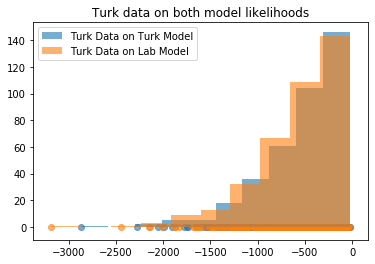

In [8]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

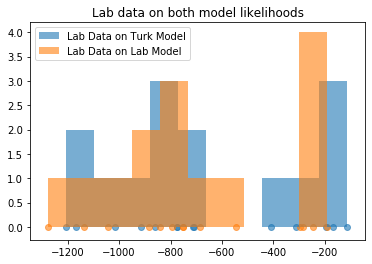

In [9]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

# Plotting results

It is hard to visulaise these results, so show them as a scatter point and a 2D histogram.
A straight line of y = x will be shown.
A point on this line will have the identily likelihoods to belong to either model.



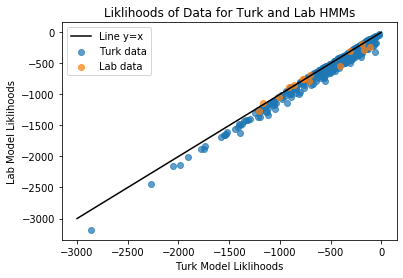

In [10]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, alpha=0.7, label='Turk data')
plt.scatter(lab_data_turk_model, lab_data_lab_model, alpha=0.7, label='Lab data')

plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
#plt.show()

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)
'''
x = np.linspace(-3000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')
'''
x = np.linspace(-3000,0,100)
y = x
plt.plot(x, y, 'k', label='Line y=x')

plt.legend()

plt.show()

# Reassigning samples

Now run all lab and turk data through both models. 
Assign a predicted label (lab / online) data.
Afterwards compare actual and predicted to see if any samples seem to be missclassified.  

In [11]:

# Test readdign samples a different way.
# If a point is above and to the left of the orange line then we can say that the data matches the lab model compared to the turk model to the same extent as the actual lab data.

def reclassify_samples(turk_model, lab_model, data, lengths):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood
        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

def reclassify_samples_regression(turk_model, lab_model, data, lengths, reg):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood

        # Y= MX + C is equation of straight line.
        # if Y > MX + C then the point is above the line    
        # https://math.stackexchange.com/questions/324589/detecting-whether-a-point-is-above-or-below-a-slope

        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( Y > M*X + C ):
            new_classes.append(1)
        else:
            new_classes.append(0)

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

# Lab data is half classified as itself. GOOD
reclassified_lab_labels = reclassify_samples(turk_model, lab_model, data_lab, lab_lengths)
reclassified_lab_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_lab, lab_lengths, reg)

print('Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels.count(0), reclassified_lab_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels_reg.count(0), reclassified_lab_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
6 8

REG Number of new turk labels, number of new lab labels:
12 16


In [12]:
reclassified_turk_labels = reclassify_samples(turk_model, lab_model, data_turk, turk_lengths)    # Try turk data
reclassified_turk_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_turk, turk_lengths, reg)    # Try turk data

print('Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels.count(0), reclassified_turk_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels_reg.count(0), reclassified_turk_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
333 45

REG Number of new turk labels, number of new lab labels:
503 253


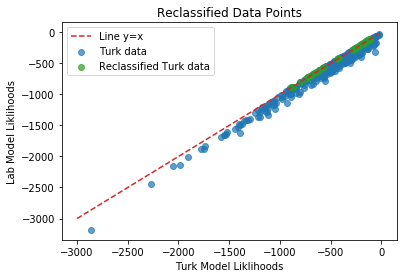

In [13]:
fig, ax = plt.subplots()

group = reclassified_turk_labels
for g in np.unique(group):
    i = np.where(group == g)
    if g == 0:
        label = 'Turk data'
        colour = 'C0'
    else:
        label = 'Reclassified Turk data'
        colour = 'C2'
    ax.scatter(np.array(turk_data_turk_model)[i], np.array(turk_data_lab_model)[i], c=colour, label=label, alpha=0.7)

#ax.scatter(lab_data_turk_model, lab_data_lab_model, c='C1', alpha=0.7, label='Lab data')

plt.title('Reclassified Data Points')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')

x = np.linspace(-3000,0,100)
y = x
plt.plot(x, y, 'C3', label='Line y=x', linestyle='dashed', alpha=1)

plt.legend()

plt.show()

# These scatterplots show that there is not anywhere near as much variance with the turk model predictions as the lab model predictions.
# Probably due to the fact we didtnt have much data to train the lab model with.
# The positive quadrant shows that shows that while the turk likelihoods are always slightly higher, theyre directly correlated and not much difference.
# Can we accume any positive likelihood from the lab model using turk data means theyre paying attention?

   Turk likelihoods  Lab likelihoods  Difference   ID
0       -860.069031      -842.451990  -17.617042  ID1
1       -775.583001      -751.082228  -24.500773  ID2
2       -773.726896      -749.746503  -23.980393  ID3
3       -312.644322      -298.308668  -14.335655  ID4
4       -195.211071      -190.477934   -4.733137  ID5


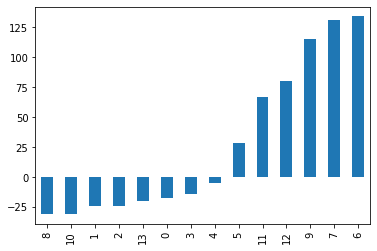

In [14]:
def compare_model_liklihoods(turk_model, lab_model, data, lengths, IDs):
    # Given a model and some data and lengths return a dataframe of each user, and the liklihoods for different models.
    # Difference is turklikelihood - lab_liklihood.
    # Therefore a high positive number means its firmly turk, a low negative number means its firmly lab.

    res = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)
        difference = turk_likelihood - lab_likelihood
        ID = IDs[i]

        res.append( (turk_likelihood, lab_likelihood, difference, ID) )

        start_i = lengths[i] 

    df = pd.DataFrame.from_records(res, columns =['Turk likelihoods', 'Lab likelihoods', 'Difference', 'ID']) 

    return df

df_lab_diff = compare_model_liklihoods(turk_model, lab_model, data_lab, lab_lengths, df_m_lab['turkId'].unique().tolist())    # Try lab data
print(df_lab_diff.head())
df_lab_diff['Difference'].sort_values().plot(kind='bar')

   Turk likelihoods  Lab likelihoods  Difference              ID
0       -137.379555      -132.472534   -4.907021  A35YFAFWP33C70
1       -124.124801      -130.289870    6.165069  A33XI8ZN4NZ0SQ
2       -220.744346      -370.936870  150.192525  A1ZG7VYH0DUEXW
3       -135.097777      -136.788861    1.691084  A1RXG8RE0SJ4LC
4        -87.854442       -97.391329    9.536887  A3BGIK3STL9345


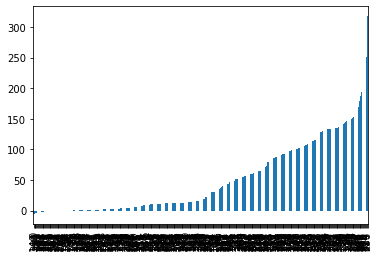

In [15]:
df_turk_diff = compare_model_liklihoods(turk_model, lab_model, data_turk, turk_lengths, df_m_turk['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

# Link between length of mouse events and likelihood?

From an breif exploration of the likelihoods and through tableau it looks like the users with longer sequences have mainly high likelihoods for turk data, and shorter sequences have higher likelihood for lab data.

Plot likelihood difference and length of mouse evetns to see if there is actually a strong correlation.



In [16]:
len(X.flatten()), len(y)

(14, 100)

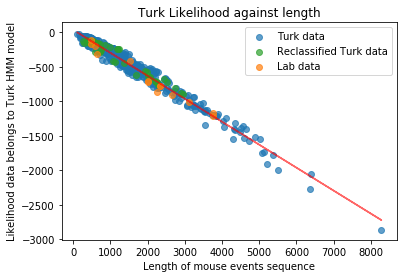

Pearsons correlation: -0.986


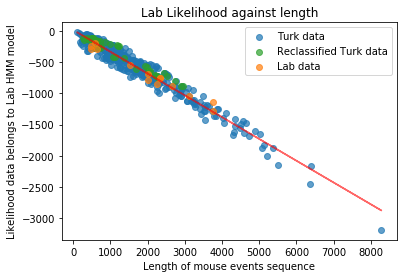

Pearsons correlation: -0.978


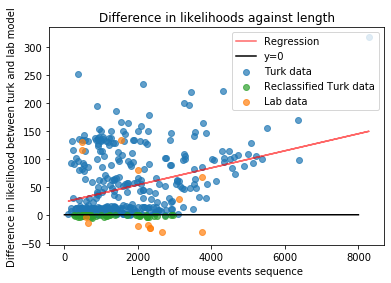

Pearsons correlation: 0.327


In [17]:
# Turk plot
fig, ax = plt.subplots()
group = reclassified_turk_labels
for g in np.unique(group):
    i = np.where(group == g)
    if g == 0:
        label = 'Turk data'
        colour = 'C0'
    else:
        label = 'Reclassified Turk data'
        colour = 'C2'
    ax.scatter(np.array(turk_lengths)[i], np.array(df_turk_diff['Turk likelihoods'])[i], c=colour, label=label, alpha=0.7)

plt.scatter(lab_lengths, df_lab_diff['Turk likelihoods'], c='C1', alpha=0.7, label='Lab data')
plt.title('Turk Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Turk HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Turk likelihoods'].append(df_lab_diff['Turk likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.legend()
plt.show()

corr, _ = pearsonr(X.flatten(), y.flatten())
print('Pearsons correlation: %.3f' % corr)

# Lab plot
fig, ax = plt.subplots()
group = reclassified_turk_labels
for g in np.unique(group):
    i = np.where(group == g)
    if g == 0:
        label = 'Turk data'
        colour = 'C0'
    else:
        label = 'Reclassified Turk data'
        colour = 'C2'
    ax.scatter(np.array(turk_lengths)[i], np.array(df_turk_diff['Lab likelihoods'])[i], c=colour, label=label, alpha=0.7)

plt.scatter(lab_lengths, df_lab_diff['Lab likelihoods'], c='C1', alpha=0.7, label='Lab data')

plt.title('Lab Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Lab HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Lab likelihoods'].append(df_lab_diff['Lab likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.legend()
plt.show()

corr, _ = pearsonr(X.flatten(), y.flatten())
print('Pearsons correlation: %.3f' % corr)

# Difference plot
fig, ax = plt.subplots()
group = reclassified_turk_labels
for g in np.unique(group):
    i = np.where(group == g)
    if g == 0:
        label = 'Turk data'
        colour = 'C0'
    else:
        label = 'Reclassified Turk data'
        colour = 'C2'
    ax.scatter(np.array(turk_lengths)[i], np.array(df_turk_diff['Difference'])[i], c=colour, label=label, alpha=0.7)

plt.scatter(lab_lengths, df_lab_diff['Difference'], c='C1', alpha=0.7, label='Lab data')
plt.title('Difference in likelihoods against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Difference in likelihood between turk and lab model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Difference'].append(df_lab_diff['Difference'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6, label='Regression')

x = np.linspace(0,8000,8000)
Y = 0*x
plt.plot(x, Y, 'k', label='y=0')
plt.legend()
plt.show()

corr, _ = pearsonr(X.flatten(), y.flatten())    
print('Pearsons correlation: %.3f' % corr)

In [18]:

reclassified_IDs = df_turk_diff[df_turk_diff['Difference'] < 0]['ID'].to_numpy()
print(len(df_turk_diff[df_turk_diff['Difference'] < 0]))
reclassified_IDs
# IDs with higher liklihood for the lab class, compared to turk class.

45


array(['A35YFAFWP33C70', 'A1FA2AJUFESR5T', 'A37MEXKALGBQWN',
       'A24DZU2LIWZQCG', 'AEZLXX7A1JLYX', 'A2Z11BHUBDVKMB',
       'A23SGBJULXN5DO', 'A19XS2I3H4JOJ8', 'A12J9J42MYQDRY',
       'A1GIA6WCGRJRY7', 'A1S0C6UI5XATJV', 'A3SFNMTK31EBV1',
       'A1QQMSG3KB5XS8', 'A3AM7D2UWBRS7Z', 'AF3TLR0FI08K0',
       'AWSCR2O3D6T87', 'AENW881YO2H8S', 'ABUNAEPK8GV63',
       'A31XNLA9REVGXL', 'A3ENEKASM9CUMS', 'A19ZHL5Y6I7GCY',
       'A3BPS4K97FAU7O', 'A313BVKYTLV6Q0', 'A1DJD0J0BTE1X8',
       'A1YJKLVJW1FE33', 'ACSZ7IOG3J5NR', 'A1YNH3KJS5NHL1',
       'A2OYWTFK9MCYJ1', 'A13FT8BNX9UUP8', 'A2VTRIPL7H0IZH',
       'AGVUHOBSCP6YC', 'AKI26MOILD9LU', 'AVXEDARJC5HLU',
       'A357X6NIBOTHH0', 'A2UIGDOLX5RV95', 'A35DUEG88GCX5J',
       'ABOEYY9Y0PFRI', 'A24I5N406D8R22', 'A2YL64PU2DBHTB',
       'A7R1OLLU1Z6RA', 'A2SWQM5X54P1O5', 'AOAZMLP27GD81',
       'A2JCK494NV7TFX', 'ACOKFBC75D5OR', 'A1ETJBNTO9ZWZ8'], dtype=object)

In [19]:
df_turk_diff.sort_values(['Difference'])['ID'].head(100).to_numpy()

array(['A31XNLA9REVGXL', 'A35YFAFWP33C70', 'A2YL64PU2DBHTB',
       'A2Z11BHUBDVKMB', 'A2VTRIPL7H0IZH', 'ACOKFBC75D5OR',
       'AKI26MOILD9LU', 'A1GIA6WCGRJRY7', 'A1YJKLVJW1FE33',
       'ACSZ7IOG3J5NR', 'A3AM7D2UWBRS7Z', 'ABOEYY9Y0PFRI',
       'A2SWQM5X54P1O5', 'A357X6NIBOTHH0', 'A24I5N406D8R22',
       'AOAZMLP27GD81', 'A1YNH3KJS5NHL1', 'A13FT8BNX9UUP8',
       'A2OYWTFK9MCYJ1', 'A37MEXKALGBQWN', 'A24DZU2LIWZQCG',
       'A1ETJBNTO9ZWZ8', 'A3ENEKASM9CUMS', 'A2UIGDOLX5RV95',
       'AENW881YO2H8S', 'A19ZHL5Y6I7GCY', 'AVXEDARJC5HLU',
       'A2JCK494NV7TFX', 'A23SGBJULXN5DO', 'AWSCR2O3D6T87',
       'AF3TLR0FI08K0', 'A35DUEG88GCX5J', 'A3SFNMTK31EBV1',
       'A7R1OLLU1Z6RA', 'A1S0C6UI5XATJV', 'A313BVKYTLV6Q0',
       'A1DJD0J0BTE1X8', 'AEZLXX7A1JLYX', 'ABUNAEPK8GV63',
       'A1FA2AJUFESR5T', 'A1QQMSG3KB5XS8', 'AGVUHOBSCP6YC',
       'A19XS2I3H4JOJ8', 'A3BPS4K97FAU7O', 'A12J9J42MYQDRY',
       'A2BA9Y6VGW6WS1', 'AYW18ODUQFXF', 'A24MK3QPZ1V1L8',
       'A2611MIM2KDWUR', 'A9N7QYMG6KIHD

## Re-create lenght against time plot with reclassified data.

Initially I created that simple plot to show data cannot easily be seperated.
This will be a good evaluation metric, if it looks linearly seperable then I wasted my time lol.

In [20]:
# Load in previous data
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

#df_turk = df_turk[ (df_turk.turkId!='A21Y22J7Q0KSGN') & (df_turk.turkId!='AKMURQ1WQN9CX') &(df_turk.turkId!='A18TCR555RWUZV') ]

# Get total time taken for a user to complete the tasks data
turk_data = df_turk.groupby('turkId').time.max().to_numpy()
lab_data  = df_lab.groupby('turkId').time.max().to_numpy()
all_data = np.append( turk_data, lab_data )

# Labels will be 1 for turk data and 0 for lab data
labels = np.append( np.ones(len(turk_data)), np.zeros(len(lab_data)) )

# Get number of mouse events data.
count_lab = df_lab.groupby('turkId').time.count().to_numpy()
count_turk = df_turk.groupby('turkId').time.count().to_numpy()
count_data = np.append( count_turk, count_lab )

Pearsons correlation: 0.344
Coefficients: 2.168157115545212
Intercept: 1434.9287589250239
Equation of the line in for y=m*X+c = y=2.168157115545212*X1434.9287589250239 


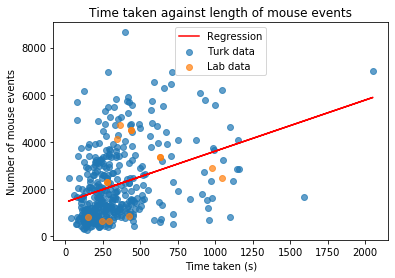

In [21]:
# It looks like the time taken and number of mouse events are not correlated.
# This is surprising.
# Calculate pearsons correlation to see correlation.
# Need value of 0.5 or above to show correlation.
# 0.286 shows strongly no correlation.

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

corr, _ = pearsonr(all_data, count_data)
print('Pearsons correlation: %.3f' % corr)

# Now plot a linear Regression to explain results visually
reg = LinearRegression().fit(all_data.reshape(-1,1), count_data.reshape(-1,1))

print(f'Coefficients: {reg.coef_[0][0]}')
print(f'Intercept: {reg.intercept_[0]}')
print(f'Equation of the line in for y=m*X+c = y={reg.coef_[0][0]}*X{reg.intercept_[0]} ')

# Difference plot
fig, ax = plt.subplots()
group = np.array(labels)
for g in [1,0]:
    i = np.where(group == g)
    if g == 0:
        label = 'Lab data'
        colour = 'C1'
    else:
        label = 'Turk data'
        colour = 'C0'
    ax.scatter(all_data[i], count_data[i], c=colour, label=label, alpha=0.7)

#plt.scatter(all_data, count_data, c=labels, alpha=0.5)
plt.title('Time taken against length of mouse events')
plt.xlabel('Time taken (s)')
plt.ylabel('Number of mouse events')

#intercept, slope, corr_coeff = plot_linear_regression(X, y)
plt.plot(all_data.reshape(-1,1), reg.coef_[0][0]*all_data.reshape(-1,1)+reg.intercept_[0], 'r', label='Regression')
plt.legend()
plt.show()

Pearsons correlation: 0.344
Coefficients: 2.168157115545212
Intercept: 1434.9287589250239
Equation of the line in for y=m*X+c = y=2.168157115545212*X1434.9287589250239 


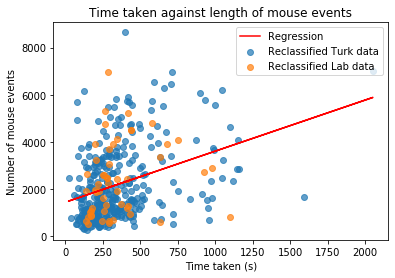

In [22]:

labels = np.append( reclassified_turk_labels, reclassified_lab_labels )

corr, _ = pearsonr(all_data, count_data)
print('Pearsons correlation: %.3f' % corr)

# Now plot a linear Regression to explain results visually
reg = LinearRegression().fit(all_data.reshape(-1,1), count_data.reshape(-1,1))

print(f'Coefficients: {reg.coef_[0][0]}')
print(f'Intercept: {reg.intercept_[0]}')
print(f'Equation of the line in for y=m*X+c = y={reg.coef_[0][0]}*X{reg.intercept_[0]} ')

# Difference plot
fig, ax = plt.subplots()
group = np.array(labels)
for g in [0,1]:
    i = np.where(group == g)
    if g == 1:
        label = 'Reclassified Lab data'
        colour = 'C1'
    else:
        label = 'Reclassified Turk data'
        colour = 'C0'
    ax.scatter(all_data[i], count_data[i], c=colour, label=label, alpha=0.7)

#plt.scatter(all_data, count_data, c=labels, alpha=0.5)
plt.title('Time taken against length of mouse events')
plt.xlabel('Time taken (s)')
plt.ylabel('Number of mouse events')

#intercept, slope, corr_coeff = plot_linear_regression(X, y)
plt.plot(all_data.reshape(-1,1), reg.coef_[0][0]*all_data.reshape(-1,1)+reg.intercept_[0], 'r', label='Regression')
plt.legend()
plt.show()

# Data generation

hmmlearn has the function .SAMPLE(n). This Generates random samples from the model.

Use this to generate new samples for lab data!

In [23]:
from scipy.stats import norm

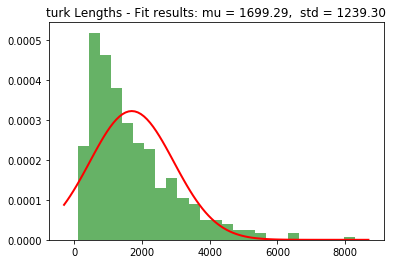

In [24]:
# See if turk data follows a distrinution

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

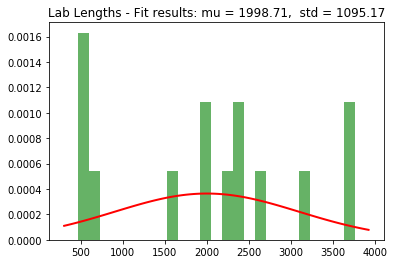

In [25]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Lab Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

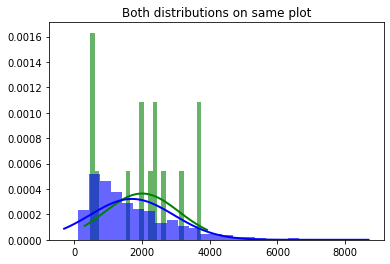

In [26]:
# Both on 1 graph?

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'g', linewidth=2)
plt.title('Both distributions on same plot')

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'b', linewidth=2)

plt.show()

Text(0.5, 1.0, 'Both Lengths - Fit results: mu = 1709.99,  std = 1235.69')

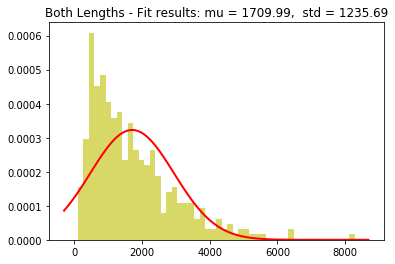

In [27]:
# Combine both data together and see what the distribution looks like
# Probably a bit pointless as the turk data will still be so much more numerous

both_lengths = np.append(turk_lengths,lab_lengths)
both_lengths = np.array(np.append(turk_lengths,lab_lengths), dtype=float)

mu, std = norm.fit(both_lengths)

plt.hist(both_lengths, bins=50, density=True, alpha=0.6, color='y')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Both Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# Length Distributions.
Can CLEARLY see a distribution off turk lengths, and we could explain you not seeing a distribtion in lab data because there is so little many samples.

For Turk and Lab the means are:

|  | Mean | S.D |
| --- | --- | --- |
| Turk | 1677 | 1235 |
| Lab | 1998 | 1095 |

Which are not identical, but as I've showed with the ealier PCA attempts lengths cannot be used to differenciate data points.
Theyre similar enough that I can assume they follow the SAME distribtion.


# Synthesize data
We can generate sequences of any length specified.
todo sample length from a normal distribution matching the lab or turk data depending on what class im creating more samples for.

In [28]:
# Shows we need to create 367 (381-14) lab samples to have classes of the same length.
# OR: synthesize 381 lab datas, then use the actual lab data as my TESTING set.
len(turk_lengths), len(lab_lengths), len(np.append(lab_lengths, turk_lengths))

(378, 14, 392)

In [29]:
# Sample points from distributions of lengths, using their mean, and sd.

num_generated_samples = len(turk_lengths)   # Create enough sampels so classes are equally sized

# Create gaussian parameters from all data, as there wasnt much difference
mu, std = norm.fit(np.append(lab_lengths, turk_lengths))

generated_lengths = np.random.normal(loc=mu, scale=std, size=num_generated_samples)   
# Creating 300 more samples would make the classes even ish.

# Remove any 0 values from generated lengths
while 0 in generated_lengths:
    generated_lengths = np.random.normal(loc=mu, scale=std, size=num_generated_samples)


# https://stackoverflow.com/a/38406535/11902832
# Remove negative values, but now its not really a normal distribution
# TODO: Try a log normal, but wasnt working for me
generated_lengths = abs(generated_lengths).astype(int)



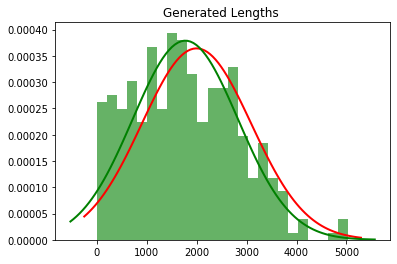

In [30]:
# Shows created data follows pretty much the same distribution as the original data.

plt.hist(generated_lengths, bins=25, density=True, alpha=0.6, color='g')

# Original lab distribution
mu, std = norm.fit(lab_lengths)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

# New generated distribution
mu, std = norm.fit(generated_lengths)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'g', linewidth=2)

title = "Generated Lengths "
plt.title(title)

plt.show()

In [31]:
# Generate the data. Note this will take a long time.

created_data = []
for i in generated_lengths:

    X, Z = lab_model.sample(i)  # This generates a new sample, length of which is taken from the normal distribution

    created_data.append( np.concatenate(X).ravel().astype(int).astype(str).tolist() ) # list of nps flattened, and to ints

len(created_data)

378

In [32]:
# we have array of length 381, each of which contains events of varing lengths.

IDs = []    # This will be the length of the flattened array. will be like ID1, ID1, ID2 etc
targets = []

for i in range(len(created_data)):    
    targets.extend(created_data[i])

    for j in range(len(created_data[i])):
        IDs.append(f'ID{i}')


In [33]:
df = pd.DataFrame({'target':targets, 'turkId':IDs}) 
df.astype(object)
#df['target'] = df['target'].rename({'0' :'html', '1':'Slider-1', '2':'Sliders-2', '3':'Slider-3', '4':'Slider-4', '5':'Slider-5'})

df['target'] = df['target'].replace('0','html')
df['target'] = df['target'].replace('1','alloc-slider-1')
df['target'] = df['target'].replace('2','alloc-slider-2')
df['target'] = df['target'].replace('3','alloc-slider-3')
df['target'] = df['target'].replace('4','alloc-slider-4')
df['target'] = df['target'].replace('5','alloc-slider-5')

df

,target,turkId
0,html,ID0
1,html,ID0
2,html,ID0
3,html,ID0
4,html,ID0
...,...,...
670800,alloc-slider-2,ID377
670801,alloc-slider-2,ID377
670802,alloc-slider-2,ID377
670803,alloc-slider-2,ID377


In [34]:
df.to_csv('created_labs.csv')

Tableau images https://imgur.com/a/FagaiQW

TODO: Remove generated lab data where not all sliders have been selected.
Some of the generated data doesnt have any records of slider-1 being selected for example

Now weve generated some more data samples see if the generated data sampels would be identified by the lab hmm not the turk hmm.



In [35]:
flatten_created_data = np.concatenate(created_data).ravel().astype(int).reshape(-1,1)


reclassified_labels = reclassify_samples(turk_model, lab_model, flatten_created_data, generated_lengths)    # Try generated lab data

print('Number of new turk labels, number of new lab labels:')
reclassified_labels.count(0), reclassified_labels.count(1)

Number of new turk labels, number of new lab labels:


(167, 211)

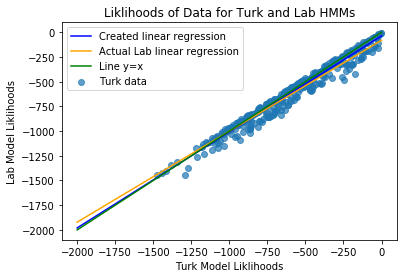

In [36]:
#############################################################################################################################

created_data_turk_model = model_score_list(turk_model, flatten_created_data, generated_lengths)
created_data_lab_model = model_score_list(lab_model, flatten_created_data, generated_lengths)

plt.scatter(created_data_turk_model, created_data_lab_model, alpha=0.7, label='Turk data')

plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
#plt.show()

# Linear reg of just lab data
X = np.array(created_data_turk_model).reshape(-1,1)
y = np.array(created_data_lab_model).reshape(-1,1)
created_reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-2000,0,100)
y = created_reg.coef_[0][0]*x + created_reg.intercept_[0]
plt.plot(x, y, 'blue', label='Created linear regression')

# Actual Lab
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)

x = np.linspace(-2000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Actual Lab linear regression')

x = np.linspace(-2000,0,100)
y = x
plt.plot(x, y, 'green', label='Line y=x')

plt.legend()

plt.show()

In [37]:
#idea: maybe the liklihoods are messed up because of the inbalanece in training size when orriginally training?
# Try duplicating training samples NOW, or retrain on the created data.

# Increaed number of iterations from 10 to 30
generated_model = hmm.MultinomialHMM(n_components=6, n_iter=50, verbose=True).fit(flatten_created_data, generated_lengths.tolist()) # not sure why not working.
generated_model

         1    -1207026.2369             +nan
         2    -1181043.7514      +25982.4855
         3    -1148298.0135      +32745.7379
         4    -1055500.7544      +92797.2591
         5     -901378.3358     +154122.4186
         6     -753577.0712     +147801.2646
         7     -617775.0401     +135802.0312
         8     -533071.3446      +84703.6955
         9     -515277.9291      +17793.4155
        10     -513675.3482       +1602.5809
        11     -513278.7581        +396.5901
        12     -512890.4928        +388.2653
        13     -511618.2992       +1272.1936
        14     -472821.0843      +38797.2149
        15     -349581.5906     +123239.4937
        16     -341964.9858       +7616.6049
        17     -341279.8184        +685.1674
        18     -341192.8628         +86.9556
        19     -341179.8524         +13.0104
        20     -341174.0026          +5.8497
        21     -341169.5119          +4.4907
        22     -341165.7112          +3.8008
        23

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=6,
               n_iter=50, params='ste',
               random_state=RandomState(MT19937) at 0x1B2F90E48C8,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [38]:
#reclassify_samples(turk_model, generated_model, data_turk, turk_lengths) 

   Turk likelihoods  Lab likelihoods  Difference              ID
0       -137.379555      -203.924929   66.545374  A35YFAFWP33C70
1       -124.124801      -254.460768  130.335966  A33XI8ZN4NZ0SQ
2       -220.744346      -424.343572  203.599227  A1ZG7VYH0DUEXW
3       -135.097777      -325.696002  190.598225  A1RXG8RE0SJ4LC
4        -87.854442       -91.378018    3.523576  A3BGIK3STL9345


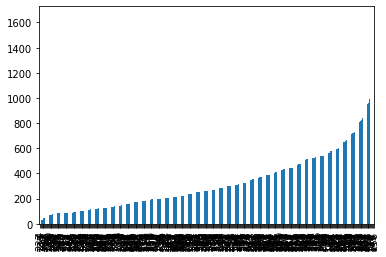

In [39]:
df_turk_diff = compare_model_liklihoods(turk_model, generated_model, data_turk, turk_lengths, df_m_turk['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

# NLP methods again 

Here I revisit the previous methods to see if they're more successful with balanced, generated data. 
See if the naive bayes of n-grams distribution will work better.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [41]:
def make_cm(cm):
    # Makes a confustion matrix
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.suptitle('0=online, 1=lab')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [42]:
created_data[0][:10]

['0', '0', '0', '0', '0', '1', '2', '2', '2', '2']

In [43]:
# Converts a pandas datafram of targets to a list of strings
def targets_to_string(dataframe):
    IDs = dataframe['turkId'].unique()
    targets_text = []

    for ID in IDs:
        targets_series = dataframe[ dataframe['turkId'] == ID ] ['target']
        targets =  ','.join(targets_series)
        targets_text.append( targets)
        #targets_text = targets

    return targets_text

df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

turk_targets = targets_to_string(df_turk)
lab_targets = targets_to_string(df_lab)
generated_targets = targets_to_string(df)

turk_labels = np.zeros( len(turk_targets) )
lab_labels = np.ones( len(lab_targets) )
generated_labels = np.ones( len(generated_targets) )


In [44]:
# TODO: I think I only get the first 114 because i only generate 100 new samples??
# TODO: Generate 381 new sampels and see how that effects accuracy of algorithms

print(len(turk_labels), len(lab_labels), len(generated_labels))

# Removed actual lab labels from training data.
X = np.concatenate((turk_targets, generated_targets)).ravel()
X_test = lab_targets
y = np.concatenate((turk_labels, generated_labels)).ravel()
y_test = lab_labels.ravel()

len(X), len(y)

378 14 378


(756, 756)

In [45]:
# OLD
# Test train split 
#X_train, X_test, y_train, y_test = train_test_split(X, y)

Accuracy: 0.59 (+/- 0.09)
f1 score: 0.57 (+/- 0.11)
accuracies:  [0.52631579 0.54966887 0.66225166 0.58278146 0.60927152]
f1 scores:   [0.50711583 0.51382576 0.65349831 0.5700339  0.58840379]
[[142 236]
 [ 79 299]]


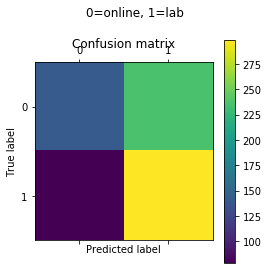

Test/Actual Lab Data:
Accuracy: 0.8571428571428571
F1 score: 0.4615384615384615
[[ 0  0]
 [ 2 12]]


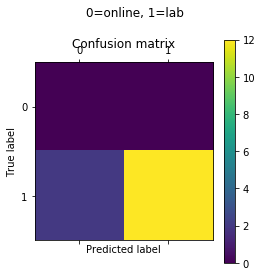

In [46]:
# Try NB model with k-cross validation

vectoriser = CountVectorizer(token_pattern='(.*?,)').fit(X)

X_vectorised = vectoriser.transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresacc.mean(), scoresacc.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

# Try NB model on actual lab / testing data
X_test_vectorised = vectoriser.transform(X_test)
classifier = MultinomialNB().fit(X_vectorised, y)
y_pred = classifier.predict(X_test_vectorised)

print('Test/Actual Lab Data:')
print( f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print( f'F1 score: {f1_score(y_test, y_pred, average="macro")}' )
cm = confusion_matrix(y_test, y_pred)
print(cm)
make_cm(cm)

In [47]:
 # This seems to say that nb finds it easiest to identify lab data as lab data.
 # This makes sence as lab data is created forom an actual model and distribution rather than being created randomly.
# THen we have to consider the actual question of the dis, can we identify whos paying attention?
# Maybe say the 12ish turks falsly predicted to be labs were paying attention??
# Seems like a big leap to say that.

 # TODO do with full dataset of 300 for turks, so generate more lab data.

# Naive Bayes with N-grams

above did naive bayes on counts of items, see if looking at ngrams effects accuracy.

Accuracy: 0.59 (+/- 0.10)
f1 score: 0.57 (+/- 0.11)
accuracies:  [0.53289474 0.54966887 0.66887417 0.58278146 0.60927152]
f1 scores:   [0.5126225  0.50992745 0.65954185 0.5700339  0.58840379]
[[142 236]
 [ 76 302]]


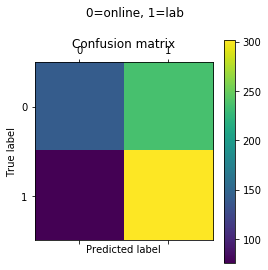

Test/Actual Lab Data:
Accuracy: 0.8571428571428571
F1 score: 0.4615384615384615
[[ 0  0]
 [ 2 12]]


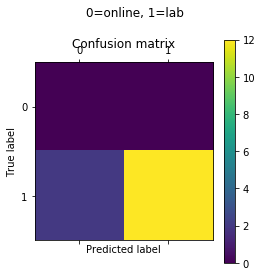

In [48]:
# Try NB model bigrams with k-cross validation

vectoriser = CountVectorizer(token_pattern='(.*?,)', ngram_range=(2, 2)).fit(X)

X_vectorised = vectoriser.transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresacc.mean(), scoresacc.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

# Try NB ngrams model on actual lab / testing data

X_test_vectorised = vectoriser.transform(X_test)
classifier = MultinomialNB().fit(X_vectorised, y)
y_pred = classifier.predict(X_test_vectorised)

print('Test/Actual Lab Data:')
print( f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print( f'F1 score: {f1_score(y_test, y_pred, average="macro")}' )
cm = confusion_matrix(y_test, y_pred)
print(cm)
make_cm(cm)

In [49]:
# AMAZING!!!!!
# Very clearly can seperate the classes looking at the bigrams!!!!!

# Still questions of how to extend that to attention or not lol.
# Potentially add section on how to generate more lab data since we cant do lab studdies because of corona.

Accuracy: 0.61 (+/- 0.10)
f1 score: 0.59 (+/- 0.12)
accuracies:  [0.55921053 0.56291391 0.69536424 0.62913907 0.60927152]
f1 scores:   [0.53453083 0.5203119  0.68369763 0.61053795 0.58840379]
[[141 237]
 [ 59 319]]


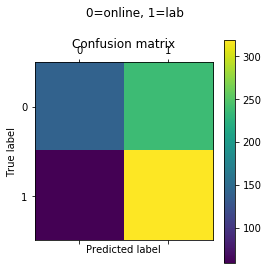

Test/Actual Lab Data:
Accuracy: 0.8571428571428571
F1 score: 0.4615384615384615
[[ 0  0]
 [ 2 12]]


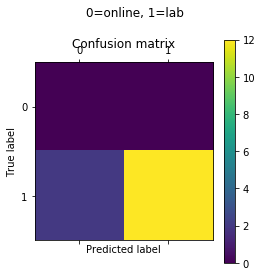

In [114]:
# Try NB model bigrams with k-cross validation

vectoriser = CountVectorizer(token_pattern='(.*?,)', ngram_range=(3, 3)).fit(X)

X_vectorised = vectoriser.transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresacc.mean(), scoresacc.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

# Try NB ngrams model on actual lab / testing data

X_test_vectorised = vectoriser.transform(X_test)
classifier = MultinomialNB().fit(X_vectorised, y)
y_pred = classifier.predict(X_test_vectorised)

print('Test/Actual Lab Data:')
print( f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print( f'F1 score: {f1_score(y_test, y_pred, average="macro")}' )
cm = confusion_matrix(y_test, y_pred)
print(cm)
make_cm(cm)